# General Imports

In [1]:
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
# Other libraries
import os
import shutil
from torch import nn
import torch
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
from os.path import join
import torch.nn.functional as F
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore') 

# CoDA imports
from data.data_handler import Data  
from training.trainer_base import Trainer  # Model trainer 
from project_utils import to_numpy, to_numpy_img  # Tensor to numpy function and formatting for imshow of tensor
from interpretability.utils import plot_contribution_map  # Plot in blue-white-red with 0-centered scale colormaps 
from interpretability.utils import matplotlib, plt, sns  # Matplotlib w/ configs
from interpretability.utils import get_pretrained  # Get pretrained imagenet model
from interpretability.utils import explainers_color_map as color_map  # Get pretrained imagenet model
from data.imagenet_classnames import name_map as name_map_all  # Imagenet class names
for k, v in color_map.items():
    color_map[k] = np.array(v, dtype=float)/255

In [3]:
class EmptyTrainer:
    
    def __init__(self, save_path, epoch=200):
        self.save_path = save_path
        self.epoch = epoch

In [4]:
resource_folder = (join(os.getcwd(), "resources"))
result_path = join(resource_folder, "results/9L-S-CoDA-SQ-1000")

## Localisation Analysis

In [5]:
trainer = EmptyTrainer(result_path)

In [6]:
from interpretability.analyses.localisation import LocalisationAnalyser

In [7]:
def load_analyser(trainer, method, explainer_config="default", analysis_config="500_3x3"):
    analyser = LocalisationAnalyser(trainer, analysis_config,
                                    plotting_only=True, explainer_config=explainer_config, verbose=False, explainer_name=method)
    analyser.get_save_folder()
    analyser.load_results()
    return analyser


In [8]:
modes = ["Ours", "IxG", "Grad", "GCam", "IntGrad", "DeepLIFT", "Occlusion"]


In [9]:
occs = ["Occ5", "Occ9"]

local_metrics = dict()

for method in modes:
    if method == "Occlusion":
        for econf in occs:
            analyser = load_analyser(trainer, method, explainer_config=econf)
            if analyser.results is not None:
                try:
                    local_metrics[method+"-"+econf] = analyser.results["localisation_metric"]
                except KeyError:
                    pass
    else:
        analyser = load_analyser(trainer, method)
        if analyser.results is not None:
            try:
                local_metrics[method] = analyser.results["localisation_metric"]
            except KeyError:
                pass

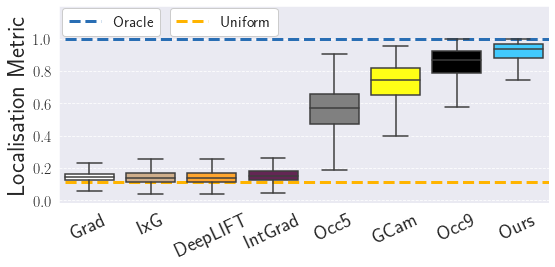

In [10]:
method = "Ours"

def mk_lbl(s):
    if s.startswith("Occlusion"):
        s = s[s.find("-")+1:]
        s = s.replace("-TI", "")
    return s

means = {k: np.nanmean(v) for k, v in local_metrics.items() if k!="Occlusion"}
stds = {k: np.nanstd(v) for k, v in local_metrics.items() if k!="Occlusion"}

sorted_keys = np.array(sorted(means.items(), key=lambda x: x[1]))[:, 0] 

fig, ax = plt.subplots(1, figsize=(8, 4))
n_imgs = 9

data = np.array([local_metrics[name] for name in sorted_keys]).T    
l1 = ax.hlines([1], -.4, len(local_metrics), alpha=1, linestyle="dashed", label="Oracle", lw=3, 
               color=np.array((41, 110, 180), dtype=float)/255, zorder=20)
l2 = ax.hlines([(1/n_imgs)], -.4, len(local_metrics), alpha=1, linestyle="dashed", lw=3,
          label="Uniform", color=np.array((255, 180, 0), dtype=float)/255, zorder=20)
box_plot = sns.boxplot(data=data, ax=ax, fliersize=0, zorder=30)
for i, k in enumerate(sorted_keys):
    mybox = box_plot.artists[i]
    mybox.set_facecolor(color_map[mk_lbl(k)])
    mybox.set_zorder(20)
    if k == "Occ5" or k == "Occ9":
        for j in range(i*6+4,i*6+6):
            line = ax.lines[j]
            line.set_color("white")
            break

ax.set_xticks(range(len(local_metrics)))

ax.set_xticklabels([(mk_lbl(s)) for s in sorted_keys], rotation=25, fontsize=20)
l1 = ax.legend([l1], ["Oracle"], loc="upper right", bbox_to_anchor=(.21, 1), facecolor="white", framealpha=1,
              borderaxespad=0.1)
ax.legend([l2], ["Uniform"], loc="upper right", bbox_to_anchor=(.45, 1), facecolor="white", framealpha=1,
         borderaxespad=0.1)

plt.gca().add_artist(l1)
ax.set_ylabel("Localisation Metric", fontsize=24)
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_ylim(ax.get_ylim()[0], 1.2)
ax.set_xlim(-.5, len(local_metrics) - 1  + .5)
ax.grid(zorder=-10, linestyle="dashed", alpha=1, axis="y")
# ax.set_title("CIFAR10", fontsize=18, fontweight="bold")
fig.tight_layout()
fig.set_facecolor("white")
# fig.savefig(result_file)
plt.show()
# print(result_file)

In [11]:
result_path_tmplt = join(resource_folder, "results/9L-S-CoDA-SQ-{norm}")

In [12]:
occs = ["Occ5", "Occ9"]

norm_results = dict()
for norm in [10, 50, 100, 500, 1000, 5000]:
    _model_path = result_path_tmplt.format(norm=norm)
    trainer = EmptyTrainer(_model_path)
    analyser = load_analyser(trainer, "Ours")
    if analyser.results is not None:
        try:
            norm_results[norm] = analyser.results["localisation_metric"]
        except KeyError:
            pass

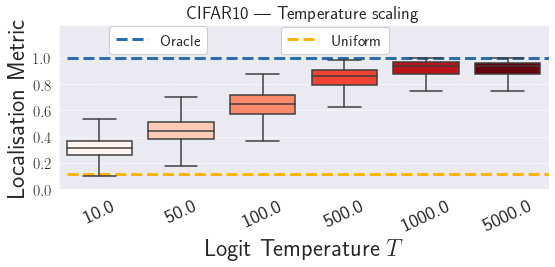

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
n_imgs = 9

sorted_keys = sorted(norm_results.keys())
data = np.array([norm_results[norm] for norm in sorted_keys]).T    
l1 = ax.hlines([1], -.4, len(norm_results), alpha=1, linestyle="dashed", label="Oracle", lw=3, 
               color=np.array((41, 110, 180), dtype=float)/255, zorder=20)
l2 = ax.hlines([(1/n_imgs)], -.4, len(norm_results), alpha=1, linestyle="dashed", lw=3,
          label="Uniform", color=np.array((255, 180, 0), dtype=float)/255, zorder=20)
box_plot = sns.boxplot(data=data, ax=ax, fliersize=0, zorder=30)
cmap = matplotlib.cm.get_cmap('Reds')
colours = [cmap(i) for i in np.linspace(0, 1, len(sorted_keys))]
for i, k in enumerate(colours):
    mybox = box_plot.artists[i]
    mybox.set_facecolor(k)
    mybox.set_zorder(20)
ax.set_xticklabels([(float(s)) for s in sorted_keys], rotation=25, fontsize=20);
ax.set_ylabel(r"Localisation Metric", fontsize=24)
ax.set_xlabel(r"Logit Temperature $T$", fontsize=24)
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_ylim(ax.get_ylim()[0], 1.25)
ax.set_xlim(-.5, len(norm_results) - 1  + .5)
ax.grid(zorder=-10, linestyle="dashed", alpha=1, axis="y")
l1 = ax.legend([l1], ["Oracle"], loc="upper left", bbox_to_anchor=(.1, 1.001), facecolor="white", framealpha=1,
              borderaxespad=0.1)
ax.legend([l2], ["Uniform"], loc="upper left", bbox_to_anchor=(.45, 1), facecolor="white", framealpha=1,
         borderaxespad=0.1)
plt.gca().add_artist(l1)
ax.set_title("CIFAR10 — Temperature scaling", fontsize=18)
fig.tight_layout()
fig.set_facecolor("white")


In [14]:
from interpretability.analyses.pixel_removal import PixelRemoveAnalyser

def load_analyser(trainer, method, analysis_config="default", explainer_config="default"):
    analyser = PixelRemoveAnalyser(trainer, analysis_config,
                                   plotting_only=True, explainer_config=explainer_config, verbose=False,
                                   explainer_name=method)
    analyser.get_save_folder()
    analyser.load_results()
    return analyser


In [15]:
occs = ["Occ5", "Occ9"]
trainer = EmptyTrainer(result_path)
removal_metrics = dict()
for method in modes:
    if method == "Occlusion":
        for econf in occs:
            analyser = load_analyser(trainer, method, explainer_config=econf)
            if analyser.results is not None:
                removal_metrics[method+"-"+econf] = analyser.results["perturbation_results"]
    else:
        
        analyser = load_analyser(trainer, method)
        if analyser.results is not None:
            removal_metrics[method] = analyser.results["perturbation_results"]

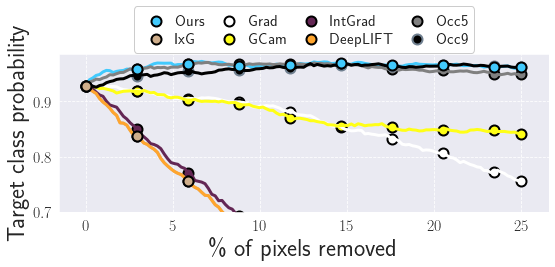

In [16]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
lines, labels = [], []
plt.subplots_adjust(right=1.2)
    
for exp_mode, mean in removal_metrics.items():
    if exp_mode.startswith("Occlusion"):
        exp_mode = exp_mode[exp_mode.find("-")+1:]
        exp_mode = exp_mode.replace("-TI", "")
    
    label = exp_mode + ("" if exp_mode in ["RISE", "LIME"] else "")
    def mk_lbl(s):
        return s

    label = mk_lbl(label)
    xvals = np.linspace(0, 100*analyser.config["num_pixels"], len(mean)) # *analyser.config["stride"], analyser.config["stride"]) / (32**2)
    edgecolor = "black" if exp_mode != "Occ9" else "slategrey"
    line, = ax.plot(xvals, mean, "-", label=label, color=color_map[exp_mode], linewidth=3)
    line = ax.scatter(list(xvals[::15])+list(xvals[-1:]) , list(mean[::15])+list(mean[-1:]) , color=color_map[exp_mode], linewidth=2, s=100,
                      marker="o",
                         **({"zorder": 3} if exp_mode in ["Ours", "IxG"] else {"zorder": 2}),
                     edgecolor=edgecolor)
    lines.append(line)
    labels.append(label)
    leg = ax.legend(lines[:], labels[:], loc="lower left", bbox_to_anchor=(.15, 1),
             facecolor="white", framealpha=1, borderaxespad=0.1, ncol=4, labelspacing=.2, handletextpad=.2,
             columnspacing=.5)
    ax.set_xlabel(r"\% of pixels removed", fontsize=24)
    ax.set_ylabel(r"Target class probability", fontsize=24)
    plt.grid(zorder=-1, alpha=1, linestyle="dashed")
    ax.set_ylim(.7, .985)
    fig.tight_layout()
    fig.set_facecolor("white")


In [17]:
occs = ["Occ5", "Occ9"]

ptb_results = dict()
for norm in [10, 50, 100, 500, 1000, 5000]:
    _model_path = result_path_tmplt.format(norm=norm)
    trainer = EmptyTrainer(_model_path)
    analyser = load_analyser(trainer, "Ours")
    if analyser.results is not None:
        try:
            ptb_results[norm] = analyser.results["perturbation_results"]
        except KeyError:
            pass

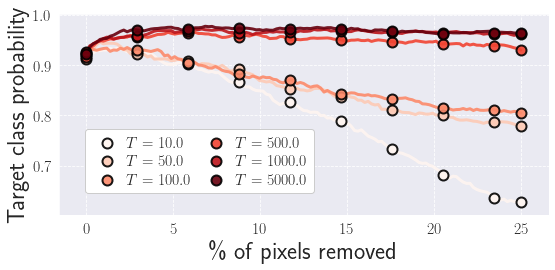

In [18]:
sorted_keys = sorted(ptb_results.keys())
fig, ax = plt.subplots(1, figsize=(8, 4))
cmap = matplotlib.cm.get_cmap('Reds')
colours = [cmap(i) for i in np.linspace(0, 1, len(sorted_keys))]
lines, labels = [], []
for c_idx, key in enumerate(sorted_keys):
    
    label = str(r"$T={:.1f}$".format(key))
    labels.append(label)
    mean = ptb_results[key]
    xvals = np.linspace(0, 100*analyser.config["num_pixels"], len(mean)) # *analyser.config["stride"], analyser.config["stride"]) / (32**2)
    edgecolor = "black"
    line, = ax.plot(xvals, mean, "-", label=label, color=colours[c_idx], linewidth=3, alpha=.9)
    line = ax.scatter(list(xvals[::15])+list(xvals[-1:]) , list(mean[::15])+list(mean[-1:]) ,
                      color=colours[c_idx], linewidth=2, s=100, zorder=3,
                     edgecolor=edgecolor, alpha=.9)
    lines.append(line)
    leg = ax.legend(lines[:], labels[:], loc="lower left", bbox_to_anchor=(.05, .1),
             facecolor="white", framealpha=1, borderaxespad=0.1, ncol=2, labelspacing=.2, handletextpad=.2,
             columnspacing=.5)
    ax.set_xlabel(r"\% of pixels removed", fontsize=24)
    ax.set_ylabel(r"Target class probability", fontsize=24)
    plt.grid(zorder=-1, alpha=1, linestyle="dashed")

fig.tight_layout()
fig.set_facecolor("white")
